# Getting GPTscore for Bamba model

## Using Bamba's output from a prompt-answer dataset and different chunking methods

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Step 0: Cloning GPT Score and setting up necessary files

In [ ]:
# Cloning personal fork of GPT score
# ** Had to make edits to GPT score in order to allow us to get scores for all 85+ model outpus. Default is 2
!rm -rf GPTScore
!git clone https://github.com/sarahkorb/GPTScore.git
%cd GPTScore
!pip install transformers accelerate

Cloning into 'GPTScore'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 59 (delta 19), reused 41 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 853.82 KiB | 2.73 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/GPTScore
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━

In [ ]:
ls

datas/  flan_score.py  gpt_inference.py  README.md     utils.py
fig/    gpt3_score.py  opt_score.py      score_d2t.py


In [ ]:
#PICKLE FILE

import pandas as pd
import pickle
from pathlib import Path

#Loading tsv file produced from benchmarking scripts.
#Change depending on which ssm module we are scoring. Below is for the default optimized:
tsv_path = "/content/drive/MyDrive/HPML/HPML Project/Benchmarking_results/accuracy_default_optimized_256.tsv"
df = pd.read_csv(tsv_path, sep="\t")

# Clean newline characters
df["reference"] = df["reference"].astype(str).str.replace("\n", " ", regex=False)
df["prediction"] = df["prediction"].astype(str).str.replace("\n", " ", regex=False)

#Convert to data dictionary with keys expected by GPT score
#will be a dictionary entry with model output, reference output, and the prompt
data_dict = {}
for i, row in df.iterrows():
    data_dict[i] = {
        'src': str(row['prompt']),
        'ref_summs': [str(row['reference'])],  # list of references, will just be our singular reference prompt for now
        'sys_summ': str(row['prediction']),
        'scores': {}
    }

# Save as pickle file in correct folder
out_path = Path("datas/meta_datas/d2t/BAMBA/data.pkl")
out_path.parent.mkdir(parents=True, exist_ok=True)
with open(out_path, "wb") as f:
    pickle.dump(data_dict, f)

print("Cleaned data.pkl saved.")




Cleaned data.pkl saved.


In [ ]:
#Sanity check: pkl file location:
ls datas/meta_datas/d2t/BAMBA/

data.pkl


In [1]:
#DEMO FILE

#GPT score also expects a demo json file which defines definitiosn of aspects on
#which to grade model scores, and examples of these
#We will not be using this (--use-demo = False in our runs) but the file needs to
#exist regardless

import json
from pathlib import Path

demo_content = {
    "asp_definition": {
        "quality": "Convert the following text into another expression that is fluent and grammatically correct:",
        "naturalness": "Convert the following text into a natural-sounding sentence, as if written by a native speaker.",
        "informativeness": "Convert the following text into another expression that preserves all important information."
    },
    "demo": {
        "quality": [],
        "naturalness": [],
        "informativeness": []
    }
}

#Saveing demo file
demo_path = Path("datas/demos/d2t/BAMBA_demos.json")
demo_path.parent.mkdir(parents=True, exist_ok=True)

with open(demo_path, "w") as f:
    json.dump(demo_content, f, indent=2)

print("dummy demo file saved.")


dummy demo file saved.


In [ ]:
ls datas/demos/d2t/

BAGEL_demos.json  BAMBA_demos.json  SFRES_demos.json


In [ ]:
!pip install mosestokenizer sacrebleu rouge-score nltk

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for mosestokenizer: filename=mosestokenizer-1.2.1-py3-none-any.whl size=49172 sha256=c707dba9b938d014c213c52db0075d944c0ffdbbba4ea458e6e65e4ff5ad1a12
  Stored in directory: /root/.cache/pip/wheels/34/cc/6e/444b747bf2adc6a0530acd6a7afda9f908b219906cfd4df2e7
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=05f8a9518f4f63c711d1564e28d1349c97ac9f0295ddfabdbafcd91c1cff17d3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=45e717

# Step 1: Run GPT Score using Bamba output

In [ ]:
#Run GPT score as suggested in README:


!python score_d2t.py \
  --dataname "BAMBA" \
  --use_demo False \
  --use_ist True \
  --gpt2_medium_score True \
  --out_dir_name "gpt2_quality_eval" \
  --aspect "quality" \
  --device "cpu"
  # --device "cuda:0"


# Recording output. Doing this all in one cell to avoid losing connection:

import pickle
import pandas as pd

# Load output from where GPTScore saved it
with open("analysis/d2t/gpt2_quality_eval/BAMBAgpt2_quality_eval_usedemo[False]_useist[True]_OptFlanGpt2_score.pkl", "rb") as f:
    results = pickle.load(f)

#Flattening the nested dictionary structure, and recording data rows for csv
rows = []
for i, sample in results.items():
    row = {
        "id": i,
        "src": sample["src"],
        "ref": sample["ref_summs"][0],
        "hyp": sample["sys_summ"],
    }
    row.update(sample["scores"])  # Adding  all score metrics (3 per aspect + averages)
    rows.append(row)

# Saving data in df
df_scores = pd.DataFrame(rows)
csv_path = "/content/drive/MyDrive/HPML/HPML Project/Benchmarking_results/BAMBA_GPTScore_256_DefOpt_results.csv"
df_scores.to_csv(csv_path, index=False)
print(f"Saved scores to: {csv_path}")


# Step 2: Visualizing Results





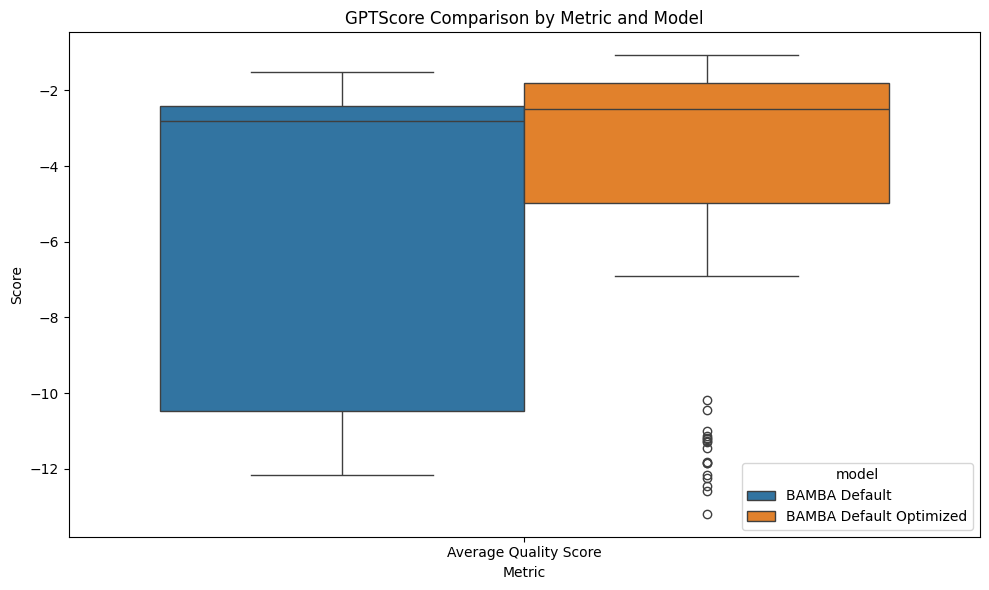

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Path dictionary to csvs where the GPT scores are recorded
#One for default, one for default optimized

paths = {
    "BAMBA Default": "/content/drive/MyDrive/HPML/HPML Project/Benchmarking_results/BAMBA_GPTScore_256results.csv",
    "BAMBA Default Optimized": "/content/drive/MyDrive/HPML/HPML Project/Benchmarking_results/BAMBA_GPTScore_256_DefOpt_results.csv",
}

#Which metrics we want to visualise (6+ to choose)
metrics = [
    "gpt2_medium_score_quality_avg_f"
]


#Creating dataset of the models and respective data
df_list = []
for model_name, path in paths.items():
    df = pd.read_csv(path)
    df["model"] = model_name
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

#melting it to make visualization easier by metric:
melted_df = pd.melt(
    combined_df,
    id_vars=["model"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

#Renaming for clarity
metric_rename_map = {
    "gpt2_medium_score_quality_avg_f": "Average Quality Score"
}

melted_df["Metric"] = melted_df["Metric"].map(metric_rename_map)

# Create boxplot with updated tick label
plt.figure(figsize=(10, 6))
sns.boxplot(x="Metric", y="Score", hue="model", data=melted_df)
plt.title("GPTScore Comparison by Metric and Model")
plt.tight_layout()
plt.show()

